## Import libraries

In [6]:
#https://www.youtube.com/watch?v=e8Yw4alG16Q
import numpy as np
import pandas as pd 
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pylab as plt
%matplotlib inline

## Data preparation

In [2]:
dataset = pd.read_csv('AirPassengers.csv')
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
dataset['Month']=pd.to_datetime(dataset['Month'],infer_datetime_format=True)
indexed_dataset=dataset.set_index(['Month'])
indexed_dataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


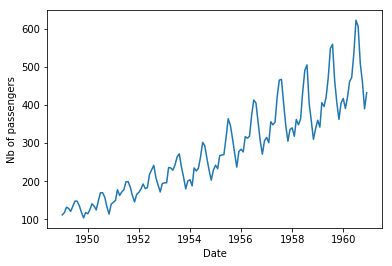

In [4]:
## plot graph 
plt.xlabel('Date')
plt.ylabel('Nb of passengers')
plt.plot(indexed_dataset)

## Stationary ?

### Method 1: Plot

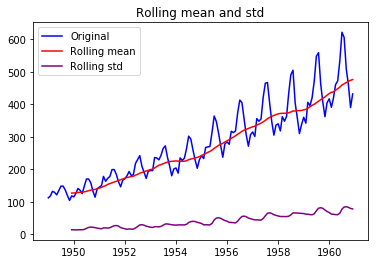

In [5]:
# Determine then plot rolling statics: original, mean, std
def determine_plot_data_mean_std_rolling(dataset,need_std):
    roll_mean = dataset.rolling(window=12).mean() # window=12, 12 months a year
    roll_std = dataset.rolling(window=12).std()
    original = plt.plot(dataset,color='blue',label='Original')
    mean = plt.plot(roll_mean,color='red',label='Rolling mean')
    if need_std==True:
        std = plt.plot(roll_std,color='purple',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show()
    return roll_mean,roll_std
    
roll_mean,roll_std=determine_plot_data_mean_std_rolling(indexed_dataset,True)
# obviously, non-stationary

### Method 2: ACF & PACF   自相关系数&偏自相关系数

/Users/FY/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


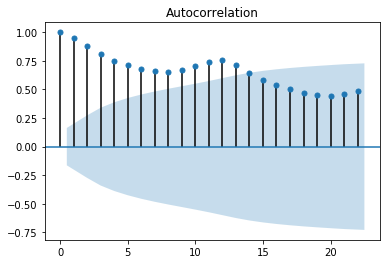

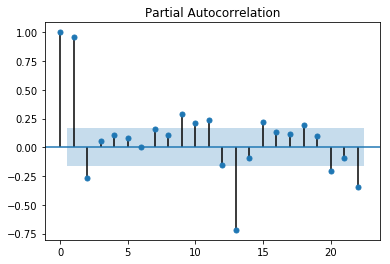

In [6]:
def plot_ACF_PACF(dataset):
    plot_acf(dataset).show()
    plot_pacf(dataset).show()

plot_ACF_PACF(indexed_dataset)
# ACF 拖尾
# PACF 不拖尾不截尾
# non-stationary

### Method 3: Duckey-Fuller Test 单位根检验

In [7]:
def df_test(dataset):
    print('Results of Duckey-Fuller test')
    dftest = adfuller(dataset['#Passengers'],autolag='AIC') 

    dfoutput = pd.Series(dftest[0:4], index=['Test statistic(adf)','p-value','used lag','Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print(dfoutput)

df_test(indexed_dataset)

# if adf < Critical value (10%) and p-value < 0.1
# or adf < Critical value (5%) and p-value < 0.05
# or adf < Critical value (1%) and p-value < 0.01
# then stationary

# In this case
# adf > Critical value (10%) and p-value > 0.1
# so non-stational

Results of Duckey-Fuller test
Test statistic(adf)             0.815369
p-value                         0.991880
used lag                       13.000000
Number of Observation Used    130.000000
Critical value (1%)            -3.481682
Critical value (5%)            -2.884042
Critical value (10%)           -2.578770
dtype: float64


## Differenciate if not stationary

In [8]:
# log transform
log_data = np.log(indexed_dataset)

### Diff Method 1: rolling mean

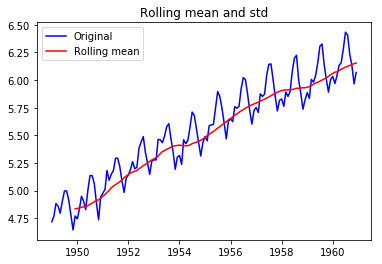

In [9]:
roll_mean,roll_std=determine_plot_data_mean_std_rolling(log_data,False)  # non diff
d_log_data_mean = log_data - roll_mean
d_log_data_mean.dropna(inplace=True)

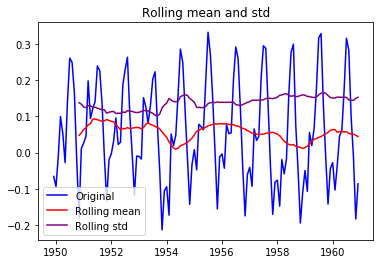

In [10]:
roll_mean,roll_std=determine_plot_data_mean_std_rolling(d_log_data_mean,True) # after 1st diff by mean

In [11]:
df_test(d_log_data_mean)

# if adf < Critical value (10%) and p-value < 0.1
# or adf < Critical value (5%) and p-value < 0.05
# or adf < Critical value (1%) and p-value < 0.01
# then stationary

# In this case
# adf < Critical value (5%) and p-value > 0.05
# stational

Results of Duckey-Fuller test
Test statistic(adf)            -3.162908
p-value                         0.022235
used lag                       13.000000
Number of Observation Used    119.000000
Critical value (1%)            -3.486535
Critical value (5%)            -2.886151
Critical value (10%)           -2.579896
dtype: float64


### Diff Method 2: exponentical decay weighted rolling mean

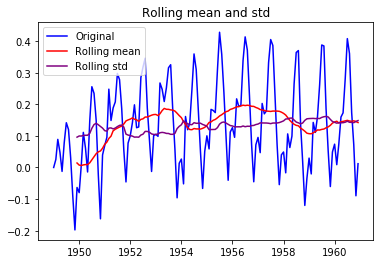

In [12]:
expDWA = log_data.ewm(halflife=12,min_periods=0,adjust=True).mean()
d_log_data_EDWA = log_data - expDWA
d_log_data_EDWA.dropna(inplace=True)
roll_mean,roll_std=determine_plot_data_mean_std_rolling(d_log_data_EDWA,True) # after 1st diff by EDWA

In [13]:
df_test(d_log_data_EDWA)  
# if adf < Critical value (10%) and p-value < 0.1
# or adf < Critical value (5%) and p-value < 0.05
# or adf < Critical value (1%) and p-value < 0.01
# then stationary

# In this case
# adf < Critical value (1%) and p-value < 0.01
# stational

Results of Duckey-Fuller test
Test statistic(adf)            -3.601262
p-value                         0.005737
used lag                       13.000000
Number of Observation Used    130.000000
Critical value (1%)            -3.481682
Critical value (5%)            -2.884042
Critical value (10%)           -2.578770
dtype: float64


### Diff Method 3: regular diff

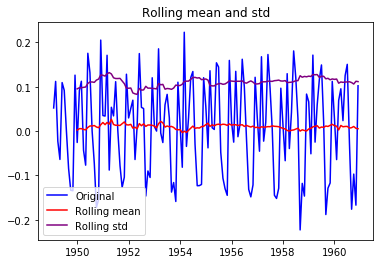

In [14]:
d_log_data = log_data.diff()
d_log_data.dropna(inplace=True)
roll_mean,roll_std=determine_plot_data_mean_std_rolling(d_log_data,True) # after 1st diff 

In [15]:
df_test(d_log_data) 
# if adf < Critical value (10%) and p-value < 0.1
# or adf < Critical value (5%) and p-value < 0.05
# or adf < Critical value (1%) and p-value < 0.01
# then stationary

# In this case
# adf < Critical value (10%) and p-value < 0.1
# stational

Results of Duckey-Fuller test
Test statistic(adf)            -2.717131
p-value                         0.071121
used lag                       14.000000
Number of Observation Used    128.000000
Critical value (1%)            -3.482501
Critical value (5%)            -2.884398
Critical value (10%)           -2.578960
dtype: float64


## Seasonal ?

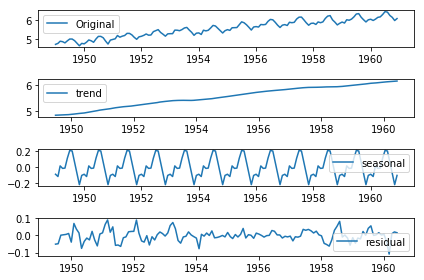

In [16]:
decomposition = seasonal_decompose(log_data)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(411)
plt.plot(log_data,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()
# seasonal

## White Noise ?

In [17]:
acorr_ljungbox(d_log_data,lags=1,return_df=True) 
# if white noise, stop analyzing, no info to extract
# p_value < 0.5, not white noise

,lb_stat,lb_pvalue
1,5.82633,0.015788


## Find rank p&q

In [18]:
from statsmodels.tsa.stattools import arma_order_select_ic
res = arma_order_select_ic(d_log_data,3,3,ic=['aic','bic'],trend='nc')
res.bic_min_order  # p, q 

(2, 2)

## Modeling

/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


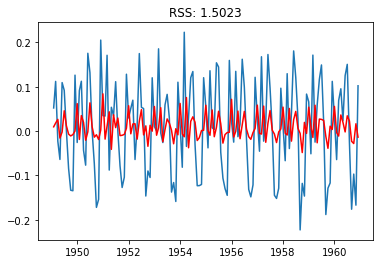

In [19]:
# AR model
model = ARIMA(log_data,order=(2,1,0)) 
results_AR = model.fit(disp=-1)
plt.plot(d_log_data)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-d_log_data['#Passengers'])**2))
print('Plotting AR model')
#RSS the smaller the better

/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


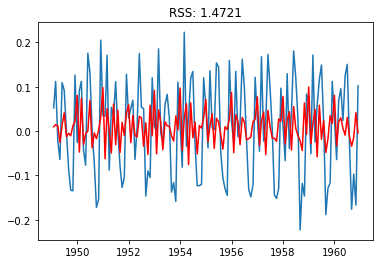

In [20]:
# MA model
model = ARIMA(log_data,order=(0,1,2)) 
results_MA = model.fit(disp=-1)
plt.plot(d_log_data)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-d_log_data['#Passengers'])**2))
print('Plotting AR model')
#RSS the smaller the better

/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/FY/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


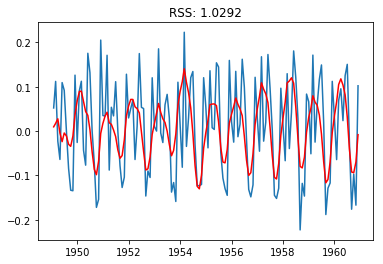

In [21]:
# ARIMA model
model = ARIMA(log_data,order=(2,1,2)) 
results_ARIMA = model.fit(disp=-1)
plt.plot(d_log_data)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-d_log_data['#Passengers'])**2))
print('Plotting ARIMA model')
#RSS the smaller the better

## Prediction

In [22]:
pred_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(pred_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [23]:
# Convert to cumulative sum
pred_ARIMA_diff_cumsum=pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [24]:
pred_ARIMA_log=pd.Series(log_data['#Passengers'].iloc[0],index=log_data.index)
pred_ARIMA_log=pred_ARIMA_log.add(pred_ARIMA_diff_cumsum,fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [25]:
pred_ARIMA=np.exp(pred_ARIMA_log)
pred_ARIMA.head()

Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073416
1949-04-01    118.301993
1949-05-01    117.768370
dtype: float64

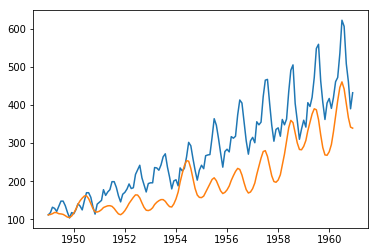

In [26]:
plt.plot(indexed_dataset)
plt.plot(pred_ARIMA)

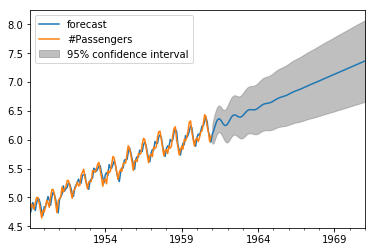

In [29]:
results_ARIMA.plot_predict(1,log_data.shape[0]+120)
x = results_ARIMA.forecast(steps=120) # 10 years

144